# Using BERT to Get Victim Name Embeddings

In [1]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os
from tqdm import tqdm

### 1) Put all the victim name csv files into one dataframe and add a column for victim name:

In [ ]:
directory = 'lynch_clusters_02_refined'

df = pd.DataFrame()

for filename in os.listdir(directory):
    victim_name = filename[:-4].replace('_', ' ')
        
    file_path = os.path.join(directory, filename)
    filler_df = pd.read_csv(file_path)
        
    filler_df['victim'] = victim_name
        
    df = pd.concat([df, filler_df], ignore_index=True)
        
df

### 2) Replace instances of victim names in the clippings with a universal 'VICTIM_NAME' token:

In [5]:
df['clippings'] = df.apply(lambda row: row['clippings'].replace(row['victim'], 'VICTIM_NAME') if isinstance(row['clippings'], str) else row['clippings'], axis=1)

### 3) Load the BERT model and add 'VICTIM_NAME' to its list of tokens:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

victim_name_token = 'VICTIM_NAME'
if victim_name_token not in tokenizer.get_vocab():
    tokenizer.add_tokens([victim_name_token])
    model.resize_token_embeddings(len(tokenizer))

# very important to do on my Mac device
# this little step makes sure BERT uses my GPUs and the code runs faster
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

### 4) Run BERT on the clippings column and save embeddings to new column called 'victim_name_embedding':

In [ ]:
# trying out progress bar. A good suggestion from Dr. LeBlanc!
tqdm.pandas()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=305)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    
    return cls_embedding

df['victim_name_embedding'] = df['clippings'].progress_apply(lambda x: get_bert_embedding(x) if isinstance(x, str) and 'VICTIM_NAME' in x else None)

df.head()

### 5) Group data by victim then mean the average of the victim name embeddings:

In [ ]:
grouped_df = df[df['victim_name_embedding'].notna()].groupby('victim')['victim_name_embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()

mean_embeddings = np.stack(grouped_df['victim_name_embedding'].values)
victim_labels = grouped_df['victim'].values

### 6) Use PCA to visualize the embeddings:

/var/folders/4l/trq3vqp90ybdgf6j37wrxx440000gn/T/ipykernel_15381/2486246436.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(mean_embeddings_2d[:, 0], mean_embeddings_2d[:, 1], alpha=0.7, cmap='viridis')


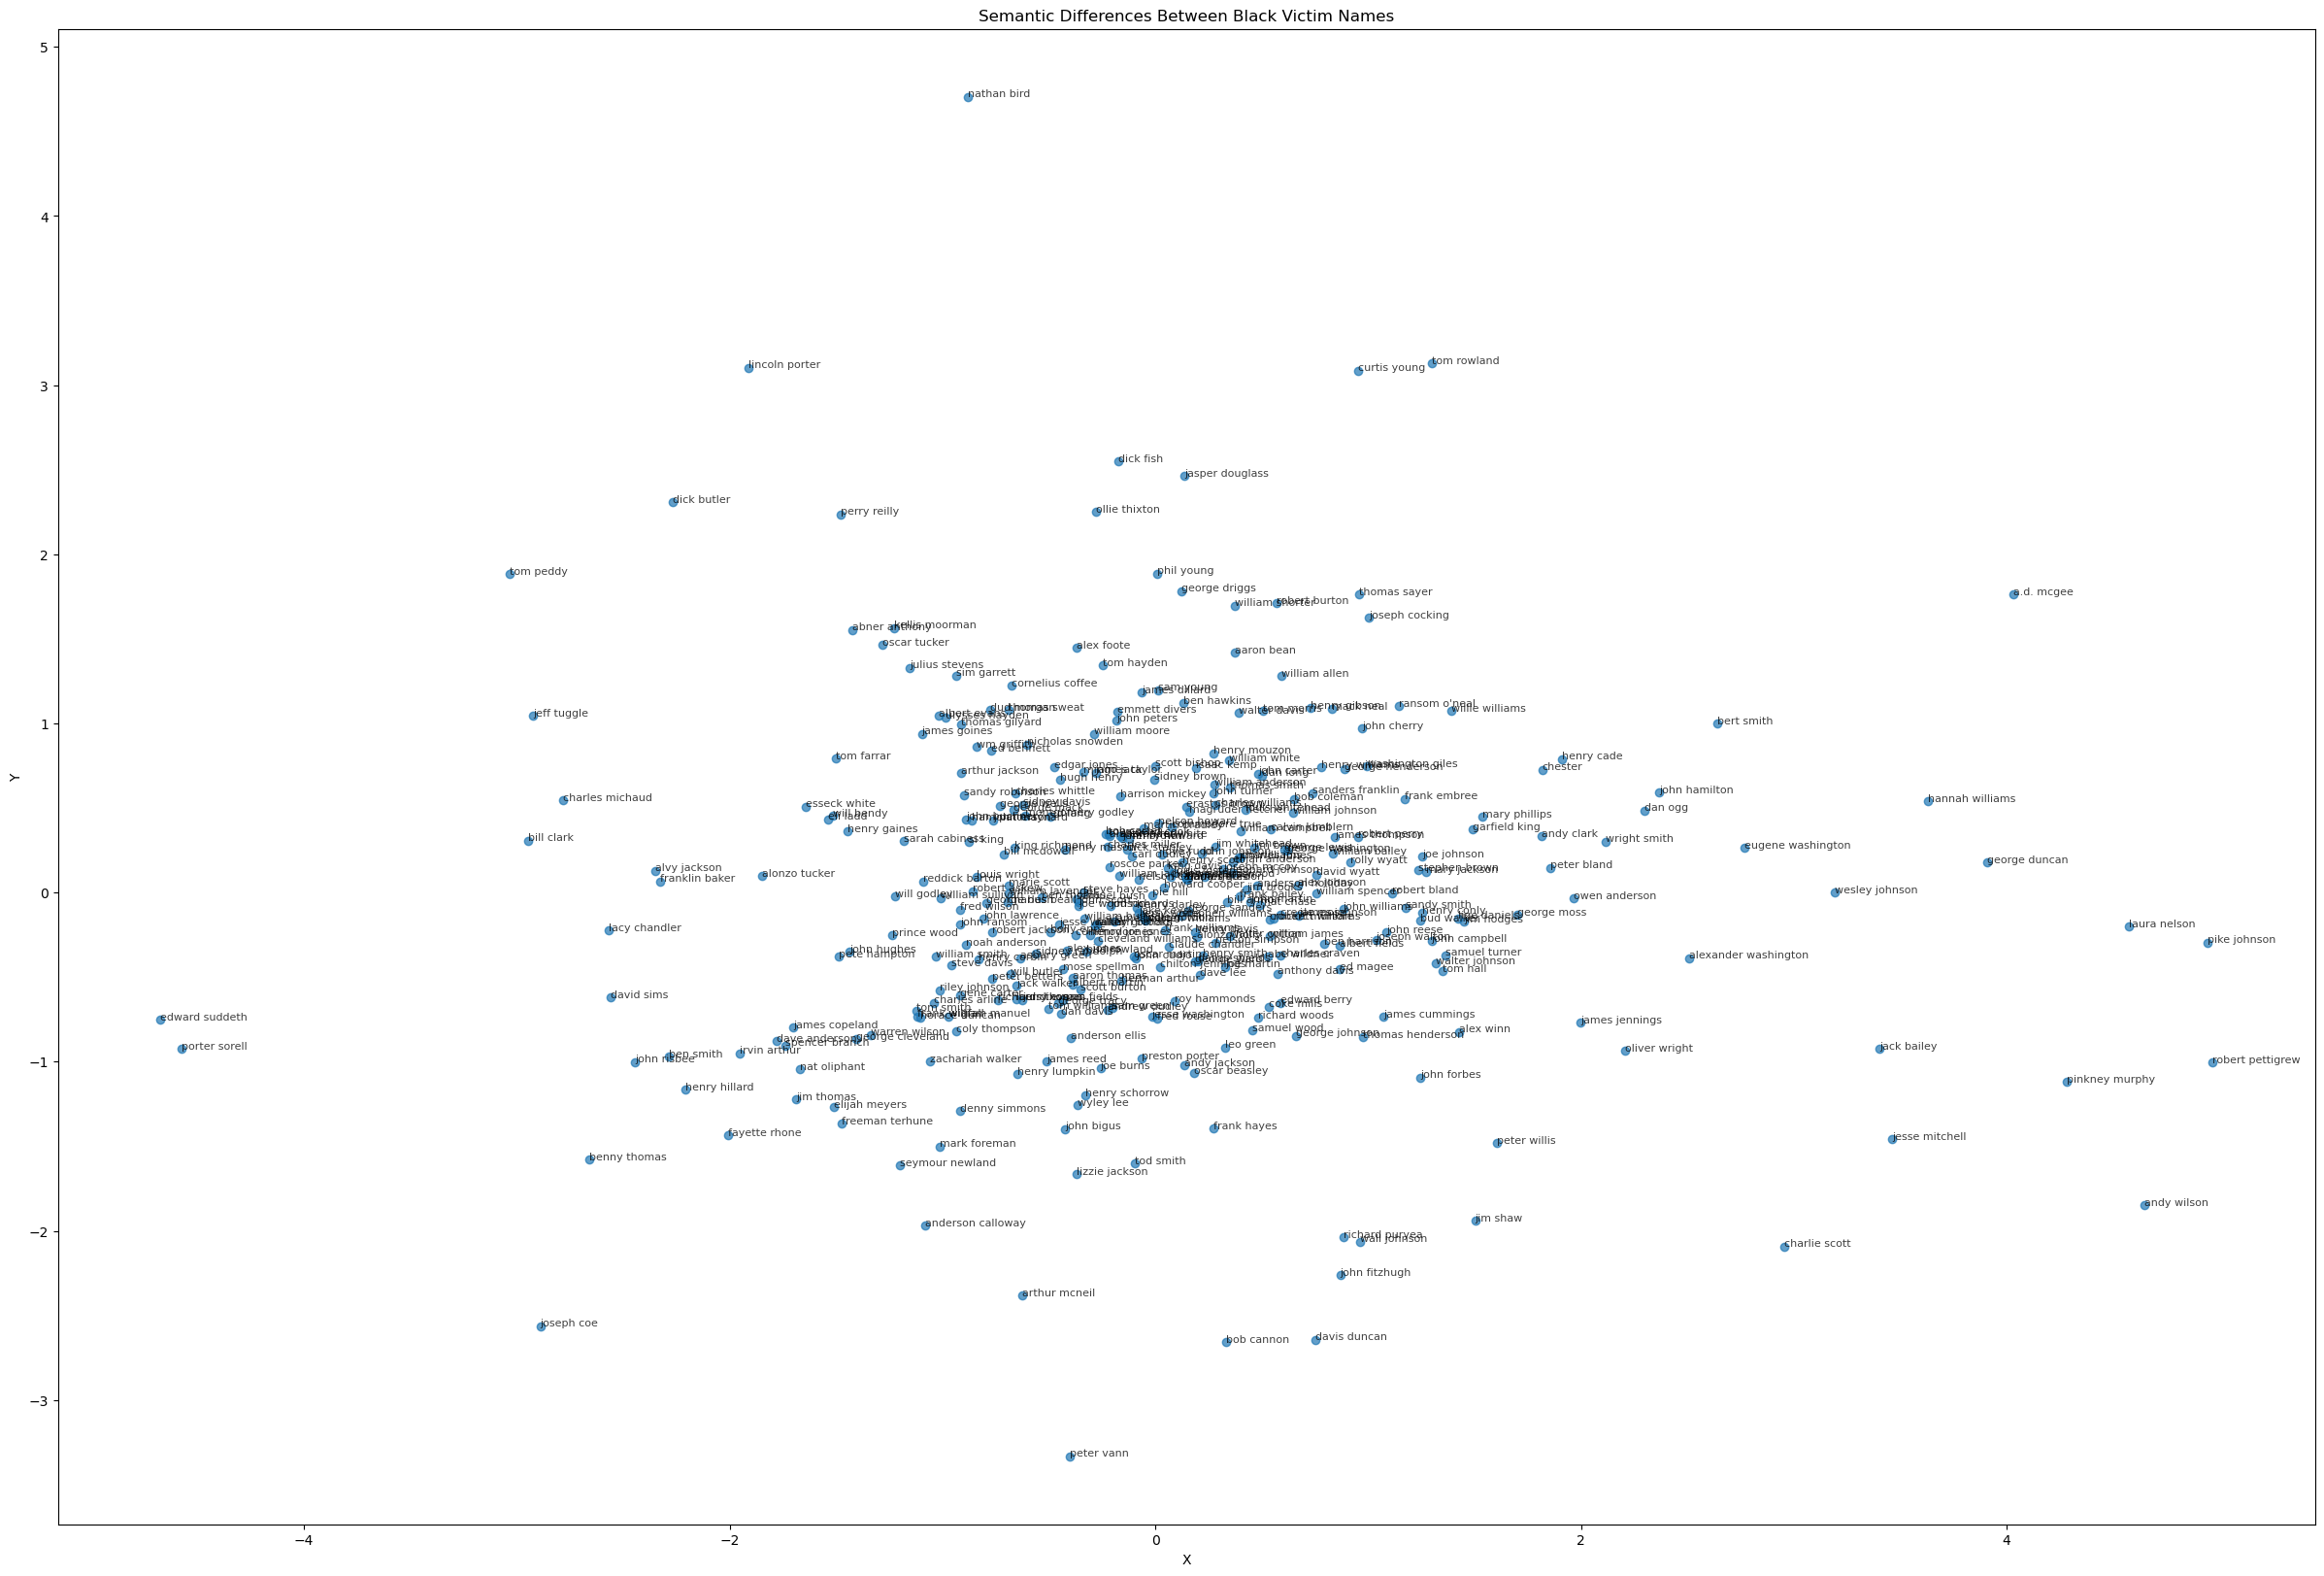

In [22]:
pca = PCA(n_components=2)
mean_embeddings_2d = pca.fit_transform(mean_embeddings)

plt.figure(figsize=(30, 20)) # this large to capture the differences
scatter = plt.scatter(mean_embeddings_2d[:, 0], mean_embeddings_2d[:, 1], alpha=0.7, cmap='viridis')
plt.title('Semantic Differences Between Black Victim Names')
plt.xlabel('X')
plt.ylabel('Y')

for i, label in enumerate(victim_labels):
    plt.annotate(label, (mean_embeddings_2d[i, 0], mean_embeddings_2d[i, 1]), fontsize=8, alpha=0.75)

plt.show()